## Kats 203 Time Series Features

This tutorial will introduce `TsFeatures` in Kats, which allows you to extract meaningful features from time series.  The table of contents for Kats 203 is as follows:

1. Basic Usage with a Single Time Series        
2. Applications with Multiple Time Series        
    2.1 Largest Seasonal Component        
    2.2 Highest Entropy ("Least Predictable")        
    2.3 Cluster Similar Time Series        
3. Out-in/out features for calculation        
    3.1 Opting-out features        
    3.2 Opting-in features        

**Note:** We provide two types of tutorial notebooks
- **Kats 101**, basic data structure and functionalities in Kats 
- **Kats 20x**, advanced topics, including advanced forecasting techniques, advanced detection algorithms, `TsFeatures`, meta-learning, etc. 

In [ ]:
%%capture
# For Google Colab:
!pip install kats

In [1]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from kats.consts import TimeSeriesData
from statsmodels.tsa.seasonal import STL
from kats.utils.simulator import Simulator
from sklearn.preprocessing import StandardScaler
from kats.tsfeatures.tsfeatures import TsFeatures

import warnings
warnings.simplefilter(action='ignore')

For the purposes of this tutorial, we are going to use the `Simulator` to generate a list of 30 different `TimeSeriesData` objects called `ts_list`.  It contains 10 time series simulated from the ARIMA model, 10 time series with trend shifts, and 10 time series with level shifts.

In [2]:
sim = Simulator(n=90, freq="D", start = "2021-01-01") # simulate 90 days of data
random_seed = 100

# generate 10 TimeSeriesData with arima_sim
np.random.seed(random_seed) # setting numpy seed
arima_sim_list = [sim.arima_sim(ar=[0.1, 0.05], ma = [0.04, 0.1], d = 1) for _ in range(10)]

# generate 10 TimeSeriesData with trend shifts
trend_sim_list = [
    sim.trend_shift_sim(
        cp_arr = [30, 60, 75],
        trend_arr=[3, 15, 2, 8],
        intercept=30,
        noise=50,
        seasonal_period=7,
        seasonal_magnitude=np.random.uniform(10, 100),
        random_seed=random_seed
    ) for _ in range(10)
]


# generate 10 TimeSeriesData with level shifts
level_shift_list = [
    sim.level_shift_sim(
        cp_arr = [30, 60, 75],
        level_arr=[1.35, 1.05, 1.35, 1.2],
        noise=0.05,
        seasonal_period=7,
        seasonal_magnitude=np.random.uniform(0.1, 1.0),
        random_seed=random_seed
    ) for _ in range(10)
]

ts_list = arima_sim_list + trend_sim_list + level_shift_list

# 1. Basic Usage with a Single Time Series
We begin by introducing the basic usage of `TsFeatures`.  For the purposes of this example, we will use the simulator to simulate a bunch of different time series from the ARIMA model.

`TsFeatures` currently can only process one time series a time, so let's start by taking a look at the first time series we generated above.

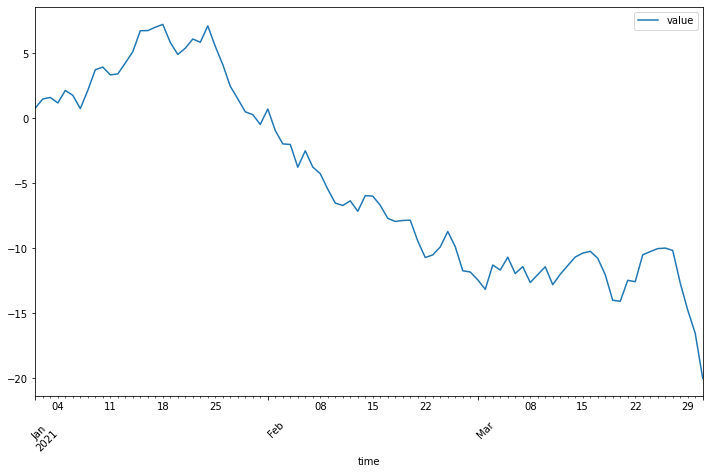

In [3]:
ts = ts_list[0]

# plot the time series
ts.plot(cols=['value'])
plt.xticks(rotation = 45)
plt.show()

Extracting the basic features from the time series using `TsFeatures` is straightforward.  We can do so as follows.

In [4]:
# Step 1. initiate TsFeatures
model = TsFeatures()

# Step 2. use .transform() method, and apply on the target time series data
output_features = model.transform(ts)
output_features

{'length': 90,
 'mean': -4.973228083549793,
 'var': 50.69499812650379,
 'entropy': 0.2742447620827895,
 'lumpiness': 10.258210327109449,
 'stability': 45.07760417461487,
 'flat_spots': 1,
 'hurst': 0.41884368965647256,
 'std1st_der': 0.8773588739369633,
 'crossing_points': 5,
 'binarize_mean': 0.43333333333333335,
 'unitroot_kpss': 0.4164114707833328,
 'heterogeneity': 73.29527168434541,
 'histogram_mode': -11.841676172131818,
 'linearity': 0.834635526909661,
 'trend_strength': 0.9853025999592567,
 'seasonality_strength': 0.3521955818150291,
 'spikiness': 0.00020455870537077636,
 'peak': 1,
 'trough': 6,
 'level_shift_idx': 23,
 'level_shift_size': 0.7134342301151566,
 'y_acf1': 0.9597578784708428,
 'y_acf5': 4.0361834721280365,
 'diff1y_acf1': 0.1830233735938267,
 'diff1y_acf5': 0.0794760417768679,
 'diff2y_acf1': -0.4816907863327952,
 'diff2y_acf5': 0.24476824866108501,
 'y_pacf5': 0.9862593061001357,
 'diff1y_pacf5': 0.07981792144706332,
 'diff2y_pacf5': 0.36145785941160113,
 'seas_

The dictionary above shows 40 features, which are the features that we calculate by default.  There are 28 additional features that we support in `TsFeatures`, and users can select which features they would like to include in their calculations using the `selected_features` argument.  We will see an example of this later.


## 2. Applications with Multiple Time Series

Now we will look at each of the time series in `ts_list` and use `TsFeatures` to calculate the features for each of them

In [5]:
model = TsFeatures()
output_features = [model.transform(ts) for ts in ts_list] # loop through time series data and perform transformation

We can view the results as a `DataFrame` as follows, which has one row for each time series in `ts_list` and each column represents a different feature.

In [6]:
df_features = pd.DataFrame(output_features) # converting to dataframe
df_features.head()

,length,mean,var,entropy,lumpiness,stability,flat_spots,hurst,std1st_der,crossing_points,...,diff2y_pacf5,seas_acf1,seas_pacf1,firstmin_ac,firstzero_ac,holt_alpha,holt_beta,hw_alpha,hw_beta,hw_gamma
0,90,-4.973228,50.694998,0.274245,10.258210,45.077604,1,0.418844,0.877359,5,...,0.361458,0.814998,0.030345,53,30,1.000000,1.365685e-01,NaN,NaN,NaN
1,90,-2.058767,10.041589,0.366121,23.888037,5.711696,1,0.449241,0.701685,8,...,0.749517,0.327535,-0.226641,21,11,0.866485,9.109527e-02,NaN,NaN,NaN
2,90,9.908474,54.513387,0.371858,44.741126,45.977900,1,0.249448,0.983165,3,...,0.324193,0.668572,0.124300,55,31,1.000000,4.547459e-10,NaN,NaN,NaN
3,90,-4.852956,21.728208,0.492625,9.067492,16.945737,1,0.377345,0.705047,11,...,0.533415,0.524764,0.009480,31,27,1.000000,6.692558e-11,NaN,NaN,NaN
4,90,-1.521848,28.601801,0.402300,259.161089,17.962647,1,0.543165,0.880529,6,...,0.460363,0.398363,-0.106916,25,16,1.000000,1.024176e-01,NaN,NaN,NaN


Now we will take a look at some of the applications of the features we have just calculated for each each of the time series in `TsFeatures`.

### 2.1 Largest Seasonal Component
We will demonstrate leveraging `TsFeatures` for finding the time series data with the highest seasonality strength among the simulated time series data.

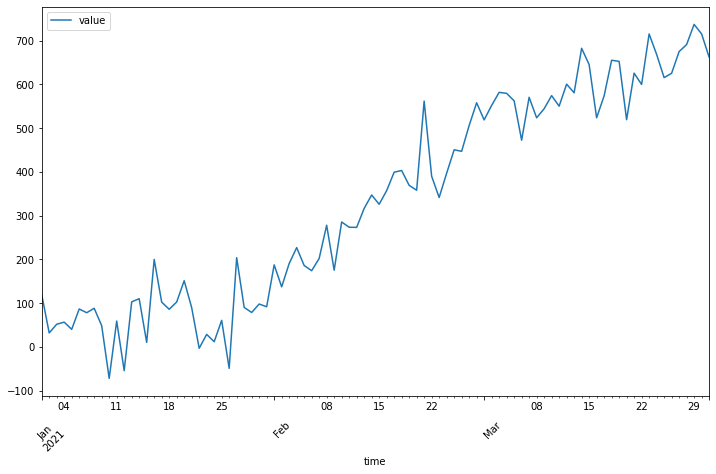

In [7]:
# finding the index of the time series sample with the highest seasonality strength
index_target_ts = df_features['seasonality_strength'].argmax() 

target_ts = ts_list[index_target_ts] 

# Plot the time series
target_ts.plot(cols=['value'])
plt.xticks(rotation = 45)
plt.show()

Now let's take a look at the STL decomposition of this time series to see its seasonal component.  We use the [`STL` module from `statsmodels`](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html).

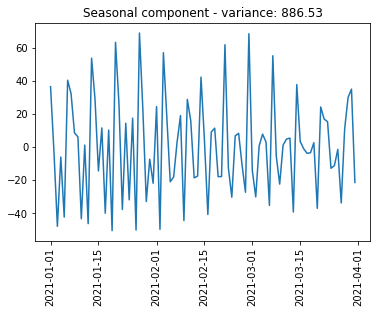

In [8]:
stl = STL(target_ts.value.values, period=7)
res = stl.fit()
plt.plot(
    pd.to_datetime(target_ts.time.values),
    res.seasonal
)
plt.xticks(rotation = 90);
plt.title(f'Seasonal component - variance: {np.round(np.var(res.seasonal), 2)}');

Now we repeat the process for the time series in `ts_list` with the smallest seasonal component.  We see that the variance of the seasonal components is much smaller in this case.

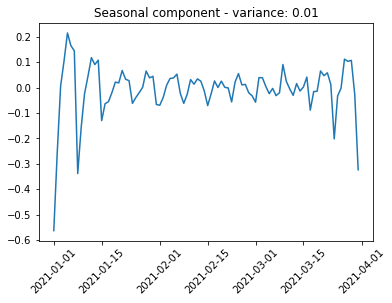

In [9]:
# finding the index of the time series sample with the smallest seasonality strength
index_target_ts = df_features['seasonality_strength'].argmin() 
target_ts = ts_list[index_target_ts].to_dataframe() 

# Do an STL decomposition and plot the results
stl = STL(target_ts.value.values, period=7)
res = stl.fit()
plt.plot(
    pd.to_datetime(target_ts.time.values),
    res.seasonal
)
plt.xticks(rotation = 45);
plt.title(f'Seasonal component - variance: {np.round(np.var(res.seasonal), 2)}');

### 2.2 Highest Entropy ("Least Predictable")

We can intuitively understand entropy as the measure of the disorder of a time series.  In general, a time series with higher entropy will be harder to forecast.  Here, we show how to use `TsFeatures` to find the time series in `ts_list` with the highest entropy.

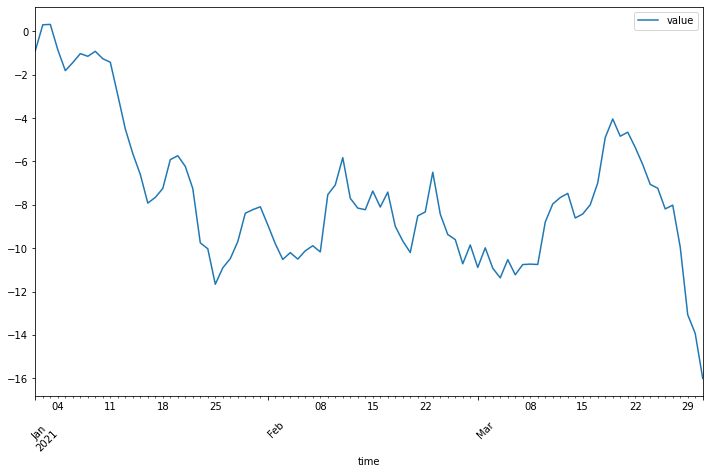

In [10]:
# find the index of the time series sample with the highest entropy
index_target_ts = df_features['entropy'].argmax() 

target_ts = ts_list[index_target_ts] 

# Plot the time series
target_ts.plot(cols=['value'])
plt.xticks(rotation = 45)
plt.show()

Let's compare the above figure with the time series data with the lowest entropy identified by `TsFeatures`.

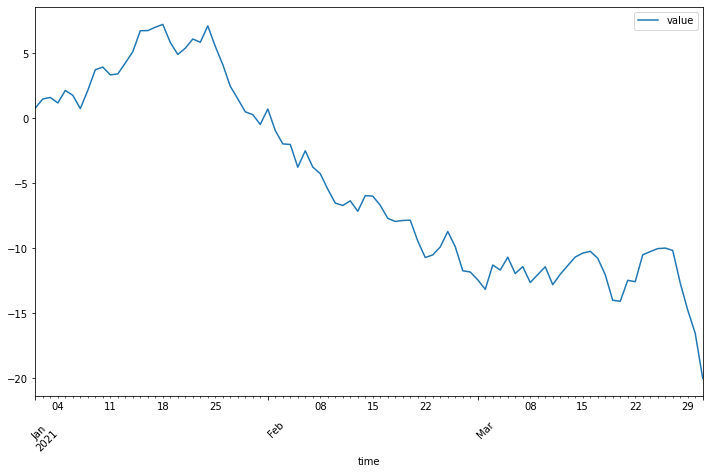

In [11]:
# find the index of the time series sample with the lowest entropy
index_target_ts = df_features['entropy'].argmin() 
target_ts = ts_list[index_target_ts]

# Plot the time series
target_ts.plot(cols=['value'])
plt.xticks(rotation = 45)
plt.show()

As we can see from the figures above, this second plot shows a time series with a clear change point and two distinct trends, suggesting it is easier to forecast than the first time series.

### 2.3 Cluster Similar Time Series

Here we are going to use the features we get from `TsFeatures` to try to cluster the time series.  

Let's perform a dimension reduction on the simulated time series data, and visualize to see if there's clear pattern of clusters.  In this example, we pick 5 features to use for each time series, and then we use `PCA` (combined with `StandardScaler`) from `sklearn` to project this representation into two dimensions.

In [12]:
# performing dimension reduction on the time series samples
ls_features = ['lumpiness', 'entropy', 'seasonality_strength', 'stability', 'level_shift_size']
df_dataset = df_features[ls_features]
x_2d = PCA(n_components=2).fit_transform(X=StandardScaler().fit_transform(df_dataset[ls_features].values))
df_dataset['pca_component_1'] = x_2d[:,0]
df_dataset['pca_component_2'] = x_2d[:,1]

Now we can plot the results below.  We have color-coded the different types of simulated time series (ARIMA, trend shift, level shift) and we can see that series of the same type are closer to each other.  

<Figure size 1080x576 with 0 Axes>

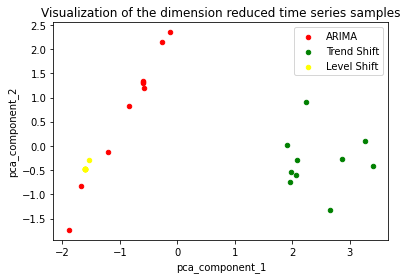

In [13]:
# Plot the PCA projections of each time series
plt.figure(figsize = (15,8))
# Plot ARIMA time series in red
ax = df_dataset.iloc[0:10].plot(x='pca_component_1', y='pca_component_2', kind='scatter', color='red')
# Plot trend shift time series in green
df_dataset.iloc[10:20].plot(x='pca_component_1', y='pca_component_2', kind='scatter', color='green', ax=ax)
# Plot level shift time series in yellow
df_dataset.iloc[20:].plot(x='pca_component_1', y='pca_component_2', kind='scatter', color='yellow', ax=ax)

plt.title('Visualization of the dimension reduced time series samples')
plt.legend(['ARIMA', 'Trend Shift', 'Level Shift'])
plt.show()

## 3. Out-in/out features for calculation

In `TsFeatures`, you can choose which features and feature groups you would like to calculate and which you would like to skip.  

### 3.1 Opting-out features

Let's start by returning to our initial example, where we calculated the first time series in `ts_list`.  This calculates the 40 features that we calculate by default.

In [14]:
ts = ts_list[0]
TsFeatures().transform(ts)

{'length': 90,
 'mean': -4.973228083549793,
 'var': 50.69499812650379,
 'entropy': 0.2742447620827895,
 'lumpiness': 10.258210327109449,
 'stability': 45.07760417461487,
 'flat_spots': 1,
 'hurst': 0.41884368965647256,
 'std1st_der': 0.8773588739369633,
 'crossing_points': 5,
 'binarize_mean': 0.43333333333333335,
 'unitroot_kpss': 0.4164114707833328,
 'heterogeneity': 73.29527168434541,
 'histogram_mode': -11.841676172131818,
 'linearity': 0.834635526909661,
 'trend_strength': 0.9853025999592567,
 'seasonality_strength': 0.3521955818150291,
 'spikiness': 0.00020455870537077636,
 'peak': 1,
 'trough': 6,
 'level_shift_idx': 23,
 'level_shift_size': 0.7134342301151566,
 'y_acf1': 0.9597578784708428,
 'y_acf5': 4.0361834721280365,
 'diff1y_acf1': 0.1830233735938267,
 'diff1y_acf5': 0.0794760417768679,
 'diff2y_acf1': -0.4816907863327952,
 'diff2y_acf5': 0.24476824866108501,
 'y_pacf5': 0.9862593061001357,
 'diff1y_pacf5': 0.07981792144706332,
 'diff2y_pacf5': 0.36145785941160113,
 'seas_

We can omit a single feature, like `seasonality_strength`, by passing `seasonality_strength=False` into `TsFeatures` like such.

In [15]:
TsFeatures(seasonality_strength=False).transform(ts)

{'length': 90,
 'mean': -4.973228083549793,
 'var': 50.69499812650379,
 'entropy': 0.2742447620827895,
 'lumpiness': 10.258210327109449,
 'stability': 45.07760417461487,
 'flat_spots': 1,
 'hurst': 0.41884368965647256,
 'std1st_der': 0.8773588739369633,
 'crossing_points': 5,
 'binarize_mean': 0.43333333333333335,
 'unitroot_kpss': 0.4164114707833328,
 'heterogeneity': 73.29527168434541,
 'histogram_mode': -11.841676172131818,
 'linearity': 0.834635526909661,
 'trend_strength': 0.9853025999592567,
 'spikiness': 0.00020455870537077636,
 'peak': 1,
 'trough': 6,
 'level_shift_idx': 23,
 'level_shift_size': 0.7134342301151566,
 'y_acf1': 0.9597578784708428,
 'y_acf5': 4.0361834721280365,
 'diff1y_acf1': 0.1830233735938267,
 'diff1y_acf5': 0.0794760417768679,
 'diff2y_acf1': -0.4816907863327952,
 'diff2y_acf5': 0.24476824866108501,
 'y_pacf5': 0.9862593061001357,
 'diff1y_pacf5': 0.07981792144706332,
 'diff2y_pacf5': 0.36145785941160113,
 'seas_acf1': 0.8149983814152568,
 'seas_pacf1': 0.0

The `seasonality_strength` feature belongs to the 'stl_features' feature group.  Each of the 68 features that we currently support in `TsFeatures` are arranged into 14 feature groups.  Below is the dictionary displaying the mapping feature feature groups and features.

In [16]:
feature_group_mapping = TsFeatures().feature_group_mapping
pprint.pprint(feature_group_mapping)

{'acfpacf_features': ['y_acf1',
                      'y_acf5',
                      'diff1y_acf1',
                      'diff1y_acf5',
                      'diff2y_acf1',
                      'diff2y_acf5',
                      'y_pacf5',
                      'diff1y_pacf5',
                      'diff2y_pacf5',
                      'seas_acf1',
                      'seas_pacf1'],
 'bocp_detector': ['bocp_num', 'bocp_conf_max', 'bocp_conf_mean'],
 'cusum_detector': ['cusum_num',
                    'cusum_conf',
                    'cusum_cp_index',
                    'cusum_delta',
                    'cusum_llr',
                    'cusum_regression_detected',
                    'cusum_stable_changepoint',
                    'cusum_p_value'],
 'holt_params': ['holt_alpha', 'holt_beta'],
 'hw_params': ['hw_alpha', 'hw_beta', 'hw_gamma'],
 'level_shift_features': ['level_shift_idx', 'level_shift_size'],
 'nowcasting': ['nowcast_roc',
                'nowcast_ma',
         

We can opt to skip the calculation of an entire feature group like `stl_features` the same way we skipped the calculation of `seasonality_strength` in the example above.

In [17]:
TsFeatures(stl_features=False).transform(ts)

{'length': 90,
 'mean': -4.973228083549793,
 'var': 50.69499812650379,
 'entropy': 0.2742447620827895,
 'lumpiness': 10.258210327109449,
 'stability': 45.07760417461487,
 'flat_spots': 1,
 'hurst': 0.41884368965647256,
 'std1st_der': 0.8773588739369633,
 'crossing_points': 5,
 'binarize_mean': 0.43333333333333335,
 'unitroot_kpss': 0.4164114707833328,
 'heterogeneity': 73.29527168434541,
 'histogram_mode': -11.841676172131818,
 'linearity': 0.834635526909661,
 'level_shift_idx': 23,
 'level_shift_size': 0.7134342301151566,
 'y_acf1': 0.9597578784708428,
 'y_acf5': 4.0361834721280365,
 'diff1y_acf1': 0.1830233735938267,
 'diff1y_acf5': 0.0794760417768679,
 'diff2y_acf1': -0.4816907863327952,
 'diff2y_acf5': 0.24476824866108501,
 'y_pacf5': 0.9862593061001357,
 'diff1y_pacf5': 0.07981792144706332,
 'diff2y_pacf5': 0.36145785941160113,
 'seas_acf1': 0.8149983814152568,
 'seas_pacf1': 0.030344962550473576,
 'firstmin_ac': 53,
 'firstzero_ac': 30,
 'holt_alpha': 0.999999985097681,
 'holt_be

We can also opt-out combinations of features and feature groups like su

In [18]:
tsf = TsFeatures(length = False, mean = False, stl_features=False)
tsf.transform(ts)

{'var': 50.69499812650379,
 'entropy': 0.2742447620827895,
 'lumpiness': 10.258210327109449,
 'stability': 45.07760417461487,
 'flat_spots': 1,
 'hurst': 0.41884368965647256,
 'std1st_der': 0.8773588739369633,
 'crossing_points': 5,
 'binarize_mean': 0.43333333333333335,
 'unitroot_kpss': 0.4164114707833328,
 'heterogeneity': 73.29527168434541,
 'histogram_mode': -11.841676172131818,
 'linearity': 0.834635526909661,
 'level_shift_idx': 23,
 'level_shift_size': 0.7134342301151566,
 'y_acf1': 0.9597578784708428,
 'y_acf5': 4.0361834721280365,
 'diff1y_acf1': 0.1830233735938267,
 'diff1y_acf5': 0.0794760417768679,
 'diff2y_acf1': -0.4816907863327952,
 'diff2y_acf5': 0.24476824866108501,
 'y_pacf5': 0.9862593061001357,
 'diff1y_pacf5': 0.07981792144706332,
 'diff2y_pacf5': 0.36145785941160113,
 'seas_acf1': 0.8149983814152568,
 'seas_pacf1': 0.030344962550473576,
 'firstmin_ac': 53,
 'firstzero_ac': 30,
 'holt_alpha': 0.999999985097681,
 'holt_beta': 0.1365684856163694,
 'hw_alpha': nan,
 

### 3.2 Opting-in features

We can use the `selected_features` argument in `TsFeatures` to specify which features and feature groups we would like to include in our calculations.  When we use this argument, a default feature will not be included unless that feature or its group is explicited included in `selected_features`.  Similarly, a feature not included by default can be included by including it or its group in `selected_features`.

Here is an example where we specify a list of features to calculate.

In [19]:
TsFeatures(selected_features = [
    'mean',
    'var',
    'entropy',
    'lumpiness',
    'hurst',
    'trend_strength',
    'y_acf1',
    'firstmin_ac',
    'holt_alpha',
    'nowcast_roc',
    'bocp_num',
    'seasonality_mag',
]).transform(ts)

{'mean': -4.973228083549793,
 'var': 50.69499812650379,
 'entropy': 0.2742447620827895,
 'lumpiness': 10.258210327109449,
 'hurst': 0.41884368965647256,
 'trend_strength': 0.9853025999592567,
 'y_acf1': 0.9597578784708428,
 'firstmin_ac': 53,
 'holt_alpha': 0.999999985097681,
 'bocp_num': 2,
 'nowcast_roc': 0.05212172487338159,
 'seasonality_mag': 1.0}

Here is an example where we specify a list of features groups to calculate.

In [20]:
TsFeatures(selected_features = [
    'statistics',
    'acfpacf_features',
    'nowcasting',
    'time',
]).transform(ts)

{'length': 90,
 'mean': -4.973228083549793,
 'var': 50.69499812650379,
 'entropy': 0.2742447620827895,
 'lumpiness': 10.258210327109449,
 'stability': 45.07760417461487,
 'flat_spots': 1,
 'hurst': 0.41884368965647256,
 'std1st_der': 0.8773588739369633,
 'crossing_points': 5,
 'binarize_mean': 0.43333333333333335,
 'unitroot_kpss': 0.4164114707833328,
 'heterogeneity': 73.29527168434541,
 'histogram_mode': -11.841676172131818,
 'linearity': 0.834635526909661,
 'y_acf1': 0.9597578784708428,
 'y_acf5': 4.0361834721280365,
 'diff1y_acf1': 0.1830233735938267,
 'diff1y_acf5': 0.0794760417768679,
 'diff2y_acf1': -0.4816907863327952,
 'diff2y_acf5': 0.24476824866108501,
 'y_pacf5': 0.9862593061001357,
 'diff1y_pacf5': 0.07981792144706332,
 'diff2y_pacf5': 0.36145785941160113,
 'seas_acf1': 0.8149983814152568,
 'seas_pacf1': 0.030344962550473576,
 'nowcast_roc': 0.05212172487338159,
 'nowcast_mom': -0.9575428298227386,
 'nowcast_ma': -4.832882514728335,
 'nowcast_lag': -4.393327628568679,
 'no

We can specify a combination of features and feature groups to calculate:

In [21]:
TsFeatures(selected_features = [
    'statistics',
    'acfpacf_features',
    'nowcasting',
    'seasonality_strength',
]).transform(ts)

{'length': 90,
 'mean': -4.973228083549793,
 'var': 50.69499812650379,
 'entropy': 0.2742447620827895,
 'lumpiness': 10.258210327109449,
 'stability': 45.07760417461487,
 'flat_spots': 1,
 'hurst': 0.41884368965647256,
 'std1st_der': 0.8773588739369633,
 'crossing_points': 5,
 'binarize_mean': 0.43333333333333335,
 'unitroot_kpss': 0.4164114707833328,
 'heterogeneity': 73.29527168434541,
 'histogram_mode': -11.841676172131818,
 'linearity': 0.834635526909661,
 'seasonality_strength': 0.3521955818150291,
 'y_acf1': 0.9597578784708428,
 'y_acf5': 4.0361834721280365,
 'diff1y_acf1': 0.1830233735938267,
 'diff1y_acf5': 0.0794760417768679,
 'diff2y_acf1': -0.4816907863327952,
 'diff2y_acf5': 0.24476824866108501,
 'y_pacf5': 0.9862593061001357,
 'diff1y_pacf5': 0.07981792144706332,
 'diff2y_pacf5': 0.36145785941160113,
 'seas_acf1': 0.8149983814152568,
 'seas_pacf1': 0.030344962550473576,
 'nowcast_roc': 0.05212172487338159,
 'nowcast_mom': -0.9575428298227386,
 'nowcast_ma': -4.832882514728

Lastly, we can mix up the opt-in and opt-out to calculate majority of the features among some feature groups, while opting-out some of the features within these feature groups that are opt-in.

We can also opt-out specific features from the feature groups we include in `selected_features`.  Here is an example where we calculate all of the features in the `statistics` group except for the `mean`.

In [22]:
TsFeatures(selected_features = ['statistics'], mean = False).transform(ts)

{'length': 90,
 'var': 50.69499812650379,
 'entropy': 0.2742447620827895,
 'lumpiness': 10.258210327109449,
 'stability': 45.07760417461487,
 'flat_spots': 1,
 'hurst': 0.41884368965647256,
 'std1st_der': 0.8773588739369633,
 'crossing_points': 5,
 'binarize_mean': 0.43333333333333335,
 'unitroot_kpss': 0.4164114707833328,
 'heterogeneity': 73.29527168434541,
 'histogram_mode': -11.841676172131818,
 'linearity': 0.834635526909661}

If we include the name of a specific feature in `selected_features` and then try to opt-out that same feature or its feature group, we will get an error.  For example, the inverse of our previous example doesn't work.

In [23]:
# THIS DOES NOT WORK
# TsFeatures(selected_features = ['mean'], statitics = False).transform(ts)

# THIS ALSO DOES NOT WORK
# TsFeatures(selected_features = ['mean'], mean = False).transform(ts)

## Conclusion

In this tutorial, we've demonstrated basic functions of `TsFeatures`, along with the demonstration of some of the interesting applications. We hope you've enjoyed the tutorial and look forward to using `TsFeatures` in the future!